In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchaudio import load, transforms
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import os
import glob
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
tf = transforms.MFCC(sample_rate=8000)

def normalize(tensor):
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean / tensor_minusmean.max()

In [5]:
class WavDataset(Dataset):
    def __init__(self, data_folder, length=300000, transform=None):
        self.data_folder = data_folder
        self.dim = length
        self.wav_list = []
        self.transform = transform

        formats = [".wav", ".WAV"]
        for root, dirnames, filenames in os.walk(data_folder):
            for filename in filenames:
                if os.path.splitext(filename)[1] in formats:
                    label = str(root).split("/")[-1]
                    self.wav_list.append([os.path.join(root, filename), label])

        
    def __getitem__(self, item):
        filename, label = self.wav_list[item]
        wb_wav, sr = load(filename)
        wb_wav = wb_wav[0, :] # 单声道

        length = len(wb_wav)
        if length >= self.dim:
               max_audio_start = length - self.dim
               audio_start = np.random.randint(0, max_audio_start)
               wb_wav = wb_wav[audio_start: audio_start + self.dim]
        else:
            wb_wav = F.pad(wb_wav, (0, self.dim - length), "constant")
        
        if self.transform is not None:
            wb_wav = normalize(self.transform(wb_wav))

        return wb_wav, sr, filename, label
 
    def __len__(self):
        return len(self.wav_list)


In [7]:
train_set= WavDataset("datasets/train/")
test_set = WavDataset("datasets/test/")

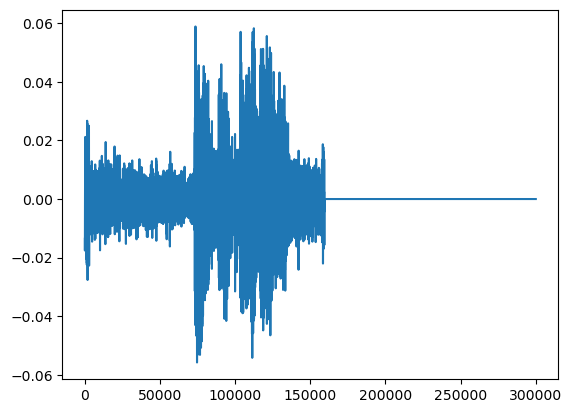

In [8]:
wavform, sr, name, label = train_set[0]
plt.plot(wavform.t().numpy());

In [9]:
labels = sorted(list(set(datapoint[-1] for datapoint in train_set)))
print(labels)

['JSY', 'WX', 'WZH', 'XXL']


In [10]:
new_sample_rate = 8000

transform   = transforms.Resample(orig_freq=sr, new_freq=new_sample_rate)
transformed = transform(wavform)

ipd.Audio(transformed, rate=new_sample_rate)

In [11]:
def label_to_index(word):
    return torch.tensor(labels.index(word))

def index_to_label(index):
    return labels[index]

word_start = "WX"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

WX --> tensor(1) --> WX


In [14]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch] # 将Tensor进行转置
    # 用0填充张量至等长度，.pad_sequence()用法可参考：https://blog.csdn.net/qq_38251616/article/details/125222012
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(1, 0)

def collate_fn(batch):
    # A data tuple has the form:
    # wb_wav, sr, filename, label
    tensors, targets = [], []
    # Gather in lists, and encode labels as indices
    for waveform, *_, label in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [15]:
for data, *_, tag in train_loader:
    specgram = normalize(tf(data))
    F.adaptive_avg_pool2d(specgram, (32, 256))

RuntimeError: Argument #4: Padding size should be less than the corresponding input dimension, but got: padding (200, 200) at dimension 2 of input [1, 300000, 12]